In [1]:
import os

In [2]:
os.chdir('/content/drive/MyDrive/KD/image')

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

In [4]:
import matplotlib.pyplot as plt
import numpy as np

In [5]:
from torchsummary import summary

In [6]:
!pip install KD-Lib

In [7]:
!pip install optuna

     |████████████████████████████████| 307kB 13.0MB/s 
     |████████████████████████████████| 81kB 10.0MB/s 
     |████████████████████████████████| 174kB 21.2MB/s 
     |████████████████████████████████| 51kB 8.8MB/s 
     |████████████████████████████████| 112kB 29.7MB/s 
     |████████████████████████████████| 143kB 24.8MB/s 
     |████████████████████████████████| 81kB 13.0MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-cp37-none-any.whl size=11138 sha256=9312c5ee740afe4b1a9238663f4a9d007e383e4a71b5b63db3d88479ab441b66
  Stored in directory: /root/.cache/pip/wheels/25/af/b8/3407109267803f4015e1ee2ff23be0c8c19ce4008665931ee1
Successfully built pyperclip


In [8]:
transform_train = transforms.Compose(
    [transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


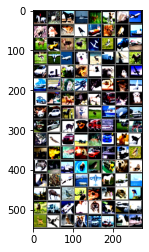

horse  deer horse  ship  deer   dog   dog plane  frog   dog  frog  bird  ship   dog  frog  ship horse   car   dog  deer plane  bird   car plane  deer plane plane   dog  deer truck  bird   dog   car truck horse  frog   cat   dog   dog plane  ship plane  bird plane   cat  frog  deer  ship   car   cat horse  frog horse truck  deer   dog   cat   car horse plane  deer  ship   car  ship truck   car  deer   dog truck plane  bird  deer  frog  bird   car plane  deer   car   dog   cat horse  frog  deer   dog   car plane truck  bird  frog  deer  ship   dog  bird truck   dog   cat  bird  frog truck  ship plane horse plane  ship  deer  deer  bird  deer  frog   cat   cat  bird  bird truck  ship   dog   dog  frog  ship plane  deer plane  bird   dog   car  ship horse  ship


In [9]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [10]:
images[0].shape

torch.Size([3, 32, 32])

In [11]:
def train(model,trainloader,optimizer,loss_fn,device):

  model.train()
  ep_loss=[]
  for batch in trainloader:

    inputs,labels=batch

    inputs,labels=inputs.to(device),labels.to(device)    
    optimizer.zero_grad()
    out=model(inputs)
    loss=loss_fn(out,labels)
    loss.backward()
    optimizer.step()
    ep_loss.append(loss.item())

  return sum(ep_loss)/len(ep_loss)



def test(model,dataloader,loss_fn,device):
  model.eval()
  correct = 0
  total = 0
  ep_loss=[]

  for batch in dataloader:

    inputs,labels=batch
    inputs,labels=inputs.to(device),labels.to(device)

    out=model(inputs)
    loss=loss_fn(out,labels)
    predicted=out.argmax(axis=1)
    total+=labels.size(0)
    correct += (predicted == labels).sum().item()
    ep_loss.append(loss.item())

  return 100*correct/total,sum(ep_loss)/len(ep_loss) 



In [12]:
device= 'cuda' if  torch.cuda.is_available() else 'cpu'

# Baseline


In [13]:
import torch.nn as nn
import torch.nn.functional as F

In [14]:
class student(nn.Module):
  def __init__(self):
    
    super().__init__()

    self.conv1=nn.Conv2d(3,64,5,padding=2)
    self.conv2=nn.Conv2d(64,64,5,padding=2)

    self.conv3=nn.Conv2d(64,128,3,padding=1)
    self.conv4=nn.Conv2d(128,128,3,padding=1)

    self.pool1=nn.MaxPool2d(2,2)
    self.pool2=nn.MaxPool2d(2,2)
    self.pool3=nn.MaxPool2d(2,2)
    
    self.fc1=nn.Linear(128*8*8,120)
    self.fc2=nn.Linear(120,84)
    
    self.fc3=nn.Linear(84,10)


  def reset_parameters(self):
    self.conv1.reset_parameters()
    self.conv2.reset_parameters()
    self.conv3.reset_parameters()
    self.conv4.reset_parameters()
    self.fc1.reset_parameters()
    self.fc2.reset_parameters()
    
  def forward(self, x):
    
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x=self.pool1(x)

    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x=self.pool2(x)

    x = torch.flatten(x, 1) 
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [15]:
std_model=student().to(device)
std_model.reset_parameters()

In [16]:
summary(std_model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           4,864
            Conv2d-2           [-1, 64, 32, 32]         102,464
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4          [-1, 128, 16, 16]          73,856
            Conv2d-5          [-1, 128, 16, 16]         147,584
         MaxPool2d-6            [-1, 128, 8, 8]               0
            Linear-7                  [-1, 120]         983,160
            Linear-8                   [-1, 84]          10,164
            Linear-9                   [-1, 10]             850
Total params: 1,322,942
Trainable params: 1,322,942
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 1.69
Params size (MB): 5.05
Estimated Total Size (MB): 6.75
---------------------------------------

In [24]:
learning_rate=0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(std_model.parameters(), lr = learning_rate, momentum=0.9,weight_decay=5e-4)
loss_fn=nn.CrossEntropyLoss()

In [19]:
import optuna

In [20]:
import sys

In [36]:
def objective(trial):

  model=student().to(device)
  model.reset_parameters()
  lr=trial.suggest_float('Learning Rate',1e-4,1e-2)
  momentum=trial.suggest_float('Momentum',0.9,0.99)
  weight_decay=trial.suggest_float('Weight Decay',5e-5,5e-3)
  model_optimiser=torch.optim.SGD(model.parameters(),lr,momentum)

  loss_fn=nn.CrossEntropyLoss()
  min_test_loss=1000
  patient=10

  for ep in range(1,101):
    train_loss=train(model,trainloader,model_optimiser,loss_fn,device)
    test_acc,test_loss=test(model,testloader,loss_fn,device)
    test_acc,test_loss,train_loss=round(test_acc,2),round(test_loss,2),round(train_loss,2)

    print(f'Epoch: {ep:02d}'
          f' Train Loss: {train_loss}'
          f' Test Loss: {test_loss}'
          f' Teat acc: {test_acc}')
    
    if min_test_loss>test_loss:
      patient=10
      min_test_loss=test_loss

    else:
      patient-=1

    if patient==0:
      break

  return min_test_loss

In [37]:
study=optuna.create_study()
study.optimize(objective,n_trials=5)

[I 2021-06-19 10:35:16,055] A new study created in memory with name: no-name-3264e8c0-784d-4072-86c3-63c3027d222a


Epoch: 01 Train Loss: 2.05 Test Loss: 1.73 Teat acc: 36.53
Epoch: 02 Train Loss: 1.64 Test Loss: 1.44 Teat acc: 46.96
Epoch: 03 Train Loss: 1.43 Test Loss: 1.26 Teat acc: 54.4
Epoch: 04 Train Loss: 1.28 Test Loss: 1.1 Teat acc: 61.07
Epoch: 05 Train Loss: 1.12 Test Loss: 0.99 Teat acc: 65.22
Epoch: 06 Train Loss: 1.0 Test Loss: 0.94 Teat acc: 67.4
Epoch: 07 Train Loss: 0.9 Test Loss: 0.8 Teat acc: 72.2
Epoch: 08 Train Loss: 0.83 Test Loss: 0.74 Teat acc: 73.99
Epoch: 09 Train Loss: 0.76 Test Loss: 0.7 Teat acc: 76.62
Epoch: 10 Train Loss: 0.71 Test Loss: 0.66 Teat acc: 77.13
Epoch: 11 Train Loss: 0.67 Test Loss: 0.63 Teat acc: 78.66
Epoch: 12 Train Loss: 0.63 Test Loss: 0.6 Teat acc: 79.85
Epoch: 13 Train Loss: 0.59 Test Loss: 0.59 Teat acc: 79.86
Epoch: 14 Train Loss: 0.57 Test Loss: 0.58 Teat acc: 80.12
Epoch: 15 Train Loss: 0.55 Test Loss: 0.57 Teat acc: 80.59
Epoch: 16 Train Loss: 0.52 Test Loss: 0.52 Teat acc: 82.37
Epoch: 17 Train Loss: 0.5 Test Loss: 0.52 Teat acc: 82.49
Epoch: 

[I 2021-06-19 10:45:02,531] Trial 0 finished with value: 0.44 and parameters: {'Learning Rate': 0.0041477271050515165, 'Momentum': 0.9377427488328196, 'Weight Decay': 0.0012601187639901508}. Best is trial 0 with value: 0.44.


Epoch: 38 Train Loss: 0.27 Test Loss: 0.44 Teat acc: 85.58
Epoch: 01 Train Loss: 1.98 Test Loss: 1.67 Teat acc: 37.91
Epoch: 02 Train Loss: 1.54 Test Loss: 1.4 Teat acc: 49.36
Epoch: 03 Train Loss: 1.29 Test Loss: 1.18 Teat acc: 58.16
Epoch: 04 Train Loss: 1.09 Test Loss: 0.98 Teat acc: 65.13
Epoch: 05 Train Loss: 0.96 Test Loss: 0.86 Teat acc: 69.66
Epoch: 06 Train Loss: 0.85 Test Loss: 0.76 Teat acc: 73.09
Epoch: 07 Train Loss: 0.77 Test Loss: 0.7 Teat acc: 76.05
Epoch: 08 Train Loss: 0.72 Test Loss: 0.69 Teat acc: 76.33
Epoch: 09 Train Loss: 0.67 Test Loss: 0.62 Teat acc: 78.77
Epoch: 10 Train Loss: 0.63 Test Loss: 0.58 Teat acc: 80.09
Epoch: 11 Train Loss: 0.59 Test Loss: 0.61 Teat acc: 79.67
Epoch: 12 Train Loss: 0.56 Test Loss: 0.56 Teat acc: 80.88
Epoch: 13 Train Loss: 0.53 Test Loss: 0.53 Teat acc: 82.09
Epoch: 14 Train Loss: 0.52 Test Loss: 0.54 Teat acc: 81.55
Epoch: 15 Train Loss: 0.49 Test Loss: 0.53 Teat acc: 81.8
Epoch: 16 Train Loss: 0.47 Test Loss: 0.52 Teat acc: 82.15


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f85f8010d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch: 30 Train Loss: 0.3 Test Loss: 0.48 Teat acc: 84.72


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f85f8010d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f85f8010d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch: 31 Train Loss: 0.3 Test Loss: 0.48 Teat acc: 85.25


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f85f8010d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f85f8010d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    self._shutdown_workers()
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
AssertionError: can only test a child process
    if w.is_alive():
  File "/usr/lib/pytho

Epoch: 32 Train Loss: 0.29 Test Loss: 0.47 Teat acc: 85.11


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f85f8010d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f85f8010d40>
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    if w.is_alive():
    self._shutdown_workers()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    if w.is_alive():
AssertionError: can only test a child process
  File "/usr/lib/pytho

Epoch: 33 Train Loss: 0.3 Test Loss: 0.46 Teat acc: 85.11


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f85f8010d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f85f8010d40>
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch: 34 Train Loss: 0.28 Test Loss: 0.44 Teat acc: 85.93


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f85f8010d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f85f8010d40>
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
AssertionError: can only test a child process
    if w.is_alive():
  File "/usr/lib/pytho

Epoch: 35 Train Loss: 0.27 Test Loss: 0.45 Teat acc: 85.93


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f85f8010d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f85f8010d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

Epoch: 36 Train Loss: 0.27 Test Loss: 0.46 Teat acc: 85.68


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f85f8010d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f85f8010d40>
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    self._shutdown_workers()
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch: 37 Train Loss: 0.27 Test Loss: 0.46 Teat acc: 85.5


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f85f8010d40>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f85f8010d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

Epoch: 38 Train Loss: 0.26 Test Loss: 0.44 Teat acc: 86.24
Epoch: 01 Train Loss: 1.99 Test Loss: 1.64 Teat acc: 39.47
Epoch: 02 Train Loss: 1.51 Test Loss: 1.33 Teat acc: 51.32
Epoch: 03 Train Loss: 1.24 Test Loss: 1.06 Teat acc: 61.83
Epoch: 04 Train Loss: 1.03 Test Loss: 0.9 Teat acc: 68.38
Epoch: 05 Train Loss: 0.9 Test Loss: 0.79 Teat acc: 72.56
Epoch: 06 Train Loss: 0.82 Test Loss: 0.77 Teat acc: 73.34
Epoch: 07 Train Loss: 0.74 Test Loss: 0.69 Teat acc: 76.26
Epoch: 08 Train Loss: 0.69 Test Loss: 0.69 Teat acc: 77.03
Epoch: 09 Train Loss: 0.66 Test Loss: 0.6 Teat acc: 79.26
Epoch: 10 Train Loss: 0.62 Test Loss: 0.57 Teat acc: 80.87
Epoch: 11 Train Loss: 0.57 Test Loss: 0.57 Teat acc: 80.45
Epoch: 12 Train Loss: 0.55 Test Loss: 0.56 Teat acc: 80.78
Epoch: 13 Train Loss: 0.53 Test Loss: 0.53 Teat acc: 81.71
Epoch: 14 Train Loss: 0.51 Test Loss: 0.53 Teat acc: 82.17
Epoch: 15 Train Loss: 0.48 Test Loss: 0.56 Teat acc: 81.01
Epoch: 16 Train Loss: 0.46 Test Loss: 0.49 Teat acc: 83.1
E

[I 2021-06-19 11:03:48,233] Trial 2 finished with value: 0.44 and parameters: {'Learning Rate': 0.0048543712691606145, 'Momentum': 0.9681368511469794, 'Weight Decay': 0.00431571052962243}. Best is trial 0 with value: 0.44.


Epoch: 35 Train Loss: 0.28 Test Loss: 0.44 Teat acc: 86.06
Epoch: 01 Train Loss: 1.99 Test Loss: 1.58 Teat acc: 42.27
Epoch: 02 Train Loss: 1.56 Test Loss: 1.39 Teat acc: 48.85
Epoch: 03 Train Loss: 1.35 Test Loss: 1.16 Teat acc: 58.67
Epoch: 04 Train Loss: 1.16 Test Loss: 1.01 Teat acc: 63.95
Epoch: 05 Train Loss: 0.99 Test Loss: 0.93 Teat acc: 67.9
Epoch: 06 Train Loss: 0.89 Test Loss: 0.78 Teat acc: 72.35
Epoch: 07 Train Loss: 0.81 Test Loss: 0.72 Teat acc: 74.85
Epoch: 08 Train Loss: 0.74 Test Loss: 0.71 Teat acc: 75.6
Epoch: 09 Train Loss: 0.69 Test Loss: 0.67 Teat acc: 77.24
Epoch: 10 Train Loss: 0.65 Test Loss: 0.62 Teat acc: 78.81
Epoch: 11 Train Loss: 0.62 Test Loss: 0.63 Teat acc: 78.64
Epoch: 12 Train Loss: 0.59 Test Loss: 0.61 Teat acc: 79.05
Epoch: 13 Train Loss: 0.56 Test Loss: 0.57 Teat acc: 80.2
Epoch: 14 Train Loss: 0.53 Test Loss: 0.52 Teat acc: 82.21
Epoch: 15 Train Loss: 0.51 Test Loss: 0.55 Teat acc: 81.32
Epoch: 16 Train Loss: 0.49 Test Loss: 0.52 Teat acc: 82.27


[I 2021-06-19 11:13:32,468] Trial 3 finished with value: 0.44 and parameters: {'Learning Rate': 0.00755660116896049, 'Momentum': 0.9185153619945801, 'Weight Decay': 0.0014606979979161386}. Best is trial 0 with value: 0.44.


Epoch: 38 Train Loss: 0.27 Test Loss: 0.44 Teat acc: 86.41
Epoch: 01 Train Loss: 2.14 Test Loss: 1.78 Teat acc: 35.06
Epoch: 02 Train Loss: 1.68 Test Loss: 1.54 Teat acc: 42.54
Epoch: 03 Train Loss: 1.44 Test Loss: 1.25 Teat acc: 54.76
Epoch: 04 Train Loss: 1.29 Test Loss: 1.18 Teat acc: 57.61
Epoch: 05 Train Loss: 1.11 Test Loss: 0.96 Teat acc: 66.34
Epoch: 06 Train Loss: 0.97 Test Loss: 0.9 Teat acc: 68.02
Epoch: 07 Train Loss: 0.88 Test Loss: 0.8 Teat acc: 71.94
Epoch: 08 Train Loss: 0.8 Test Loss: 0.72 Teat acc: 75.26
Epoch: 09 Train Loss: 0.74 Test Loss: 0.75 Teat acc: 74.33
Epoch: 10 Train Loss: 0.7 Test Loss: 0.66 Teat acc: 77.22
Epoch: 11 Train Loss: 0.64 Test Loss: 0.61 Teat acc: 79.61
Epoch: 12 Train Loss: 0.62 Test Loss: 0.6 Teat acc: 79.67
Epoch: 13 Train Loss: 0.58 Test Loss: 0.59 Teat acc: 79.98
Epoch: 14 Train Loss: 0.54 Test Loss: 0.54 Teat acc: 82.2
Epoch: 15 Train Loss: 0.53 Test Loss: 0.57 Teat acc: 81.06
Epoch: 16 Train Loss: 0.5 Test Loss: 0.55 Teat acc: 81.37
Epoc

[I 2021-06-19 11:24:17,210] Trial 4 finished with value: 0.44 and parameters: {'Learning Rate': 0.0016252675141156393, 'Momentum': 0.9820052535473529, 'Weight Decay': 0.0036739514963604002}. Best is trial 0 with value: 0.44.


Epoch: 42 Train Loss: 0.24 Test Loss: 0.44 Teat acc: 86.75


In [40]:
study.best_value

0.44

In [38]:
study.best_params

{'Learning Rate': 0.0041477271050515165,
 'Momentum': 0.9377427488328196,
 'Weight Decay': 0.0012601187639901508}

In [39]:
std_model_para=study.best_params

# Teacher model

In [41]:
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F

In [42]:
device= 'cuda' if  torch.cuda.is_available() else 'cpu'
learning_rate = 0.001

In [ ]:
parent = models.vgg16(pretrained = True)
input_lastLayer = parent.classifier[6].in_features
parent.classifier[6] = nn.Linear(input_lastLayer,10)
parent = parent.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(parent.parameters(), lr = learning_rate, momentum=0.9,weight_decay=5e-4)

In [46]:
def objective(trial):

  model=models.vgg16(pretrained = True)
  input_lastLayer = model.classifier[6].in_features
  model.classifier[6] = nn.Linear(input_lastLayer,10)
  model = model.to(device)
  lr=trial.suggest_float('Learning Rate',1e-4,1e-2)
  momentum=trial.suggest_float('Momentum',0.9,0.99)
  weight_decay=trial.suggest_float('Weight Decay',5e-5,5e-3)
  model_optimiser=torch.optim.SGD(model.parameters(),lr,momentum)

  loss_fn=nn.CrossEntropyLoss()
  min_test_loss=1000
  patient=10

  for ep in range(1,101):
    train_loss=train(model,trainloader,model_optimiser,loss_fn,device)
    test_acc,test_loss=test(model,testloader,loss_fn,device)
    test_acc,test_loss,train_loss=round(test_acc,2),round(test_loss,2),round(train_loss,2)

    print(f'Epoch: {ep:02d}'
          f' Train Loss: {train_loss}'
          f' Test Loss: {test_loss}'
          f' Teat acc: {test_acc}')
    
    if min_test_loss>test_loss:
      patient=10
      min_test_loss=test_loss

    else:
      patient-=1

    if patient==0:
      break

  return min_test_loss

In [47]:
study=optuna.create_study()
study.optimize(objective,n_trials=5)

[I 2021-06-19 11:29:19,795] A new study created in memory with name: no-name-e42062cb-6135-47ec-9abc-0f09700493f0


Epoch: 01 Train Loss: 0.97 Test Loss: 0.73 Teat acc: 76.53
Epoch: 02 Train Loss: 0.58 Test Loss: 0.5 Teat acc: 84.06
Epoch: 03 Train Loss: 0.47 Test Loss: 0.44 Teat acc: 85.29
Epoch: 04 Train Loss: 0.41 Test Loss: 0.42 Teat acc: 86.47
Epoch: 05 Train Loss: 0.38 Test Loss: 0.43 Teat acc: 86.42
Epoch: 06 Train Loss: 0.33 Test Loss: 0.35 Teat acc: 88.58
Epoch: 07 Train Loss: 0.29 Test Loss: 0.38 Teat acc: 87.24
Epoch: 08 Train Loss: 0.28 Test Loss: 0.35 Teat acc: 88.86
Epoch: 09 Train Loss: 0.25 Test Loss: 0.36 Teat acc: 88.25
Epoch: 10 Train Loss: 0.24 Test Loss: 0.37 Teat acc: 88.87
Epoch: 11 Train Loss: 0.22 Test Loss: 0.34 Teat acc: 89.05
Epoch: 12 Train Loss: 0.21 Test Loss: 0.31 Teat acc: 89.81
Epoch: 13 Train Loss: 0.19 Test Loss: 0.35 Teat acc: 88.69
Epoch: 14 Train Loss: 0.18 Test Loss: 0.36 Teat acc: 89.05
Epoch: 15 Train Loss: 0.17 Test Loss: 0.35 Teat acc: 89.73
Epoch: 16 Train Loss: 0.15 Test Loss: 0.33 Teat acc: 89.66
Epoch: 17 Train Loss: 0.15 Test Loss: 0.36 Teat acc: 89.5

[I 2021-06-19 11:39:52,219] Trial 0 finished with value: 0.31 and parameters: {'Learning Rate': 0.004898421146727127, 'Momentum': 0.9678538737136412, 'Weight Decay': 0.00462304634300897}. Best is trial 0 with value: 0.31.


Epoch: 22 Train Loss: 0.12 Test Loss: 0.33 Teat acc: 90.32
Epoch: 01 Train Loss: 0.87 Test Loss: 0.56 Teat acc: 80.86
Epoch: 02 Train Loss: 0.53 Test Loss: 0.48 Teat acc: 83.68
Epoch: 03 Train Loss: 0.43 Test Loss: 0.4 Teat acc: 86.3
Epoch: 04 Train Loss: 0.37 Test Loss: 0.39 Teat acc: 87.15
Epoch: 05 Train Loss: 0.33 Test Loss: 0.41 Teat acc: 86.48
Epoch: 06 Train Loss: 0.3 Test Loss: 0.35 Teat acc: 88.22
Epoch: 07 Train Loss: 0.27 Test Loss: 0.34 Teat acc: 88.63
Epoch: 08 Train Loss: 0.24 Test Loss: 0.35 Teat acc: 88.88
Epoch: 09 Train Loss: 0.22 Test Loss: 0.35 Teat acc: 88.82
Epoch: 10 Train Loss: 0.2 Test Loss: 0.33 Teat acc: 89.34
Epoch: 11 Train Loss: 0.19 Test Loss: 0.33 Teat acc: 89.59
Epoch: 12 Train Loss: 0.17 Test Loss: 0.33 Teat acc: 89.28
Epoch: 13 Train Loss: 0.16 Test Loss: 0.34 Teat acc: 89.5
Epoch: 14 Train Loss: 0.15 Test Loss: 0.34 Teat acc: 89.49
Epoch: 15 Train Loss: 0.14 Test Loss: 0.37 Teat acc: 89.3
Epoch: 16 Train Loss: 0.12 Test Loss: 0.34 Teat acc: 90.06
Epo

[I 2021-06-19 11:49:27,320] Trial 1 finished with value: 0.33 and parameters: {'Learning Rate': 0.002794812618113172, 'Momentum': 0.9271985248504214, 'Weight Decay': 0.004849425973983083}. Best is trial 0 with value: 0.31.


Epoch: 20 Train Loss: 0.1 Test Loss: 0.35 Teat acc: 90.3
Epoch: 01 Train Loss: 0.87 Test Loss: 0.62 Teat acc: 79.08
Epoch: 02 Train Loss: 0.53 Test Loss: 0.49 Teat acc: 84.05
Epoch: 03 Train Loss: 0.43 Test Loss: 0.43 Teat acc: 85.83
Epoch: 04 Train Loss: 0.38 Test Loss: 0.4 Teat acc: 86.96
Epoch: 05 Train Loss: 0.33 Test Loss: 0.4 Teat acc: 86.83
Epoch: 06 Train Loss: 0.3 Test Loss: 0.38 Teat acc: 87.75
Epoch: 07 Train Loss: 0.26 Test Loss: 0.38 Teat acc: 87.55
Epoch: 08 Train Loss: 0.24 Test Loss: 0.35 Teat acc: 88.9
Epoch: 09 Train Loss: 0.22 Test Loss: 0.34 Teat acc: 89.11
Epoch: 10 Train Loss: 0.21 Test Loss: 0.34 Teat acc: 89.49
Epoch: 11 Train Loss: 0.19 Test Loss: 0.4 Teat acc: 87.8
Epoch: 12 Train Loss: 0.17 Test Loss: 0.34 Teat acc: 89.91
Epoch: 13 Train Loss: 0.15 Test Loss: 0.38 Teat acc: 88.52
Epoch: 14 Train Loss: 0.15 Test Loss: 0.32 Teat acc: 90.14
Epoch: 15 Train Loss: 0.14 Test Loss: 0.35 Teat acc: 90.47
Epoch: 16 Train Loss: 0.13 Test Loss: 0.33 Teat acc: 90.68
Epoch

[I 2021-06-19 12:00:58,518] Trial 2 finished with value: 0.32 and parameters: {'Learning Rate': 0.005876522382536186, 'Momentum': 0.936132424398122, 'Weight Decay': 0.004503463582819904}. Best is trial 0 with value: 0.31.


Epoch: 24 Train Loss: 0.09 Test Loss: 0.34 Teat acc: 90.73
Epoch: 01 Train Loss: 0.86 Test Loss: 0.57 Teat acc: 80.92
Epoch: 02 Train Loss: 0.53 Test Loss: 0.51 Teat acc: 83.44
Epoch: 03 Train Loss: 0.44 Test Loss: 0.42 Teat acc: 86.0
Epoch: 04 Train Loss: 0.36 Test Loss: 0.38 Teat acc: 87.39
Epoch: 05 Train Loss: 0.33 Test Loss: 0.39 Teat acc: 87.72
Epoch: 06 Train Loss: 0.29 Test Loss: 0.37 Teat acc: 87.28
Epoch: 07 Train Loss: 0.26 Test Loss: 0.4 Teat acc: 87.6
Epoch: 08 Train Loss: 0.23 Test Loss: 0.35 Teat acc: 88.61
Epoch: 09 Train Loss: 0.21 Test Loss: 0.34 Teat acc: 88.72
Epoch: 10 Train Loss: 0.2 Test Loss: 0.37 Teat acc: 88.6
Epoch: 11 Train Loss: 0.18 Test Loss: 0.35 Teat acc: 89.3
Epoch: 12 Train Loss: 0.17 Test Loss: 0.33 Teat acc: 90.1
Epoch: 13 Train Loss: 0.16 Test Loss: 0.35 Teat acc: 89.79
Epoch: 14 Train Loss: 0.15 Test Loss: 0.34 Teat acc: 90.02
Epoch: 15 Train Loss: 0.14 Test Loss: 0.36 Teat acc: 89.8
Epoch: 16 Train Loss: 0.13 Test Loss: 0.34 Teat acc: 89.65
Epoch

[I 2021-06-19 12:11:31,704] Trial 3 finished with value: 0.33 and parameters: {'Learning Rate': 0.007529839512380999, 'Momentum': 0.9167462665663436, 'Weight Decay': 0.0012054405495708256}. Best is trial 0 with value: 0.31.


Epoch: 22 Train Loss: 0.09 Test Loss: 0.38 Teat acc: 89.97
Epoch: 01 Train Loss: 0.9 Test Loss: 0.59 Teat acc: 79.76
Epoch: 02 Train Loss: 0.54 Test Loss: 0.5 Teat acc: 83.75
Epoch: 03 Train Loss: 0.43 Test Loss: 0.41 Teat acc: 86.13
Epoch: 04 Train Loss: 0.37 Test Loss: 0.39 Teat acc: 86.82
Epoch: 05 Train Loss: 0.33 Test Loss: 0.38 Teat acc: 88.06
Epoch: 06 Train Loss: 0.29 Test Loss: 0.32 Teat acc: 89.14
Epoch: 07 Train Loss: 0.27 Test Loss: 0.33 Teat acc: 89.43
Epoch: 08 Train Loss: 0.24 Test Loss: 0.35 Teat acc: 88.58
Epoch: 09 Train Loss: 0.21 Test Loss: 0.33 Teat acc: 89.22
Epoch: 10 Train Loss: 0.2 Test Loss: 0.34 Teat acc: 88.98
Epoch: 11 Train Loss: 0.18 Test Loss: 0.3 Teat acc: 90.46
Epoch: 12 Train Loss: 0.17 Test Loss: 0.33 Teat acc: 89.95
Epoch: 13 Train Loss: 0.15 Test Loss: 0.34 Teat acc: 89.92
Epoch: 14 Train Loss: 0.15 Test Loss: 0.34 Teat acc: 90.1
Epoch: 15 Train Loss: 0.14 Test Loss: 0.31 Teat acc: 90.5
Epoch: 16 Train Loss: 0.13 Test Loss: 0.34 Teat acc: 89.99
Epo

[I 2021-06-19 12:21:36,385] Trial 4 finished with value: 0.3 and parameters: {'Learning Rate': 0.002571229405350465, 'Momentum': 0.9642863845123816, 'Weight Decay': 0.0011319178194984176}. Best is trial 4 with value: 0.3.


Epoch: 21 Train Loss: 0.1 Test Loss: 0.36 Teat acc: 89.78


In [48]:
study.best_value

0.3

In [49]:
study.best_params

{'Learning Rate': 0.002571229405350465,
 'Momentum': 0.9642863845123816,
 'Weight Decay': 0.0011319178194984176}

In [ ]:
summary(parent,(3,32,32))

# KD

In [50]:
!pip install KD-Lib

In [51]:
!pip install optuna

In [52]:
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F

In [58]:
device= 'cuda' if  torch.cuda.is_available() else 'cpu'

In [59]:
parent = models.vgg16(pretrained = True)
input_lastLayer = parent.classifier[6].in_features
parent.classifier[6] = nn.Linear(input_lastLayer,10)
parent_criterion = nn.CrossEntropyLoss()
parent_optimizer = torch.optim.SGD(parent.parameters(), lr = 0.0025, momentum=0.96,weight_decay=11e-4)

In [60]:
class student(nn.Module):
  def __init__(self):
    
    super().__init__()

    self.conv1=nn.Conv2d(3,64,5,padding=2)
    self.conv2=nn.Conv2d(64,64,5,padding=2)

    self.conv3=nn.Conv2d(64,128,3,padding=1)
    self.conv4=nn.Conv2d(128,128,3,padding=1)

    self.pool1=nn.MaxPool2d(2,2)
    self.pool2=nn.MaxPool2d(2,2)
    self.pool3=nn.MaxPool2d(2,2)
    
    self.fc1=nn.Linear(128*8*8,120)
    self.fc2=nn.Linear(120,84)
    
    self.fc3=nn.Linear(84,10)


  def reset_parameters(self):
    self.conv1.reset_parameters()
    self.conv2.reset_parameters()
    self.conv3.reset_parameters()
    self.conv4.reset_parameters()
    self.fc1.reset_parameters()
    self.fc2.reset_parameters()
    
  def forward(self, x):
    
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x=self.pool1(x)

    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x=self.pool2(x)

    x = torch.flatten(x, 1) 
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [61]:
std_model=student()
std_model.reset_parameters()

In [62]:
std_optimizer=torch.optim.SGD(std_model.parameters(),lr=0.004,momentum=0.9, weight_decay=12e-4)
std_loss_fn=nn.CrossEntropyLoss()
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [63]:
from KD_Lib.KD import VanillaKD


In [64]:
import optuna

In [65]:
distiller=VanillaKD(teacher_model=parent,student_model=std_model,train_loader=trainloader,val_loader=testloader,optimizer_teacher=parent_optimizer,optimizer_student=std_optimizer,device=device)

Training Teacher... 
--------------------------------------------------------------------------------
Validation Accuracy: 0.8048
Epoch: 1, Loss: 344.9662780761719, Accuracy: 0.69794
--------------------------------------------------------------------------------
Validation Accuracy: 0.839
Epoch: 2, Loss: 202.68296813964844, Accuracy: 0.82484
--------------------------------------------------------------------------------
Validation Accuracy: 0.8535
Epoch: 3, Loss: 164.1180419921875, Accuracy: 0.85904
--------------------------------------------------------------------------------
Validation Accuracy: 0.8689
Epoch: 4, Loss: 143.00563049316406, Accuracy: 0.87618
--------------------------------------------------------------------------------
Validation Accuracy: 0.8714
Epoch: 5, Loss: 125.08361053466797, Accuracy: 0.89154
--------------------------------------------------------------------------------
Validation Accuracy: 0.8755
Epoch: 6, Loss: 113.83902740478516, Accuracy: 0.90132
----

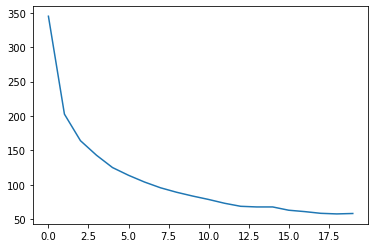

In [66]:
distiller.train_teacher(epochs=20, plot_losses=True, save_model=True)

Training Student...
--------------------------------------------------------------------------------
Validation Accuracy: 0.2552
Epoch: 1, Loss: 466.1565707921982, Accuracy: 0.1574
--------------------------------------------------------------------------------
Validation Accuracy: 0.3732
Epoch: 2, Loss: 397.04558354616165, Accuracy: 0.2997
--------------------------------------------------------------------------------
Validation Accuracy: 0.4223
Epoch: 3, Loss: 357.8741332888603, Accuracy: 0.36598
--------------------------------------------------------------------------------
Validation Accuracy: 0.4544
Epoch: 4, Loss: 332.2228448987007, Accuracy: 0.41192
--------------------------------------------------------------------------------
Validation Accuracy: 0.5055
Epoch: 5, Loss: 312.167468726635, Accuracy: 0.45116
--------------------------------------------------------------------------------
Validation Accuracy: 0.5122
Epoch: 6, Loss: 298.98705238103867, Accuracy: 0.47588
---------

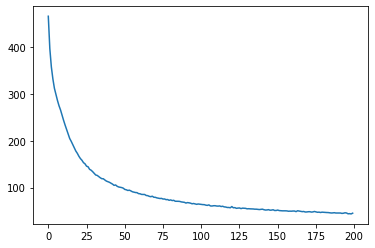

In [67]:
distiller.train_student(epochs=200, plot_losses=True, save_model=True)

In [68]:
distiller.evaluate(teacher=False) 

--------------------------------------------------------------------------------
Validation Accuracy: 0.8699


0.8699